In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("punkt")
import seaborn as sns
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
df=pd.read_csv("/kaggle/input/medicaltranscriptions/mtsamples.csv")
df=df.fillna("nil")
df=df.drop(columns=["Unnamed: 0"])

In [24]:
df.isnull().sum()

description          0
medical_specialty    0
sample_name          0
transcription        0
keywords             0
dtype: int64

In [25]:
def text_preprocessing(text):
    data=text.lower()
    data_re=re.sub(r'\W+'," ",data)
    data_tokenizer=word_tokenize(data_re)
    tokens=[word for word in data_tokenizer if word not in stopwords.words("english")]
    return " ".join(tokens)

In [26]:
df["description"]=df["description"].apply(text_preprocessing)
df["medical_specialty"]=df["medical_specialty"].apply(text_preprocessing)
df["transcription"]=df["transcription"].apply(text_preprocessing)
df["keywords"]=df["keywords"].apply(text_preprocessing)

In [49]:
one_hot=OneHotEncoder(sparse_output=False)
one=one_hot.fit_transform(df[["medical_specialty"]])
one=pd.DataFrame(one,columns=one_hot.get_feature_names_out())

In [56]:
one.shape

(4999, 40)

In [51]:
df

,description,medical_specialty,sample_name,transcription,keywords
0,23 year old white female presents complaint al...,allergy immunology,Allergic Rhinitis,subjective 23 year old white female presents c...,allergy immunology allergic rhinitis allergies...
1,consult laparoscopic gastric bypass,bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history difficulty climbing stair...,bariatrics laparoscopic gastric bypass weight ...
2,consult laparoscopic gastric bypass,bariatrics,Laparoscopic Gastric Bypass Consult - 1,history present illness seen abc today pleasan...,bariatrics laparoscopic gastric bypass heart a...
3,2 mode doppler,cardiovascular pulmonary,2-D Echocardiogram - 1,2 mode 1 left atrial enlargement left atrial d...,cardiovascular pulmonary 2 mode doppler aortic...
4,2 echocardiogram,cardiovascular pulmonary,2-D Echocardiogram - 2,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary 2 doppler echocardiog...
...,...,...,...,...,...
4994,patient severe sinusitis two three months ago ...,allergy immunology,Chronic Sinusitis,history pleasure meeting evaluating patient re...,nil
4995,14 month old baby boy caucasian came presumpti...,allergy immunology,Kawasaki Disease - Discharge Summary,admitting diagnosis kawasaki disease discharge...,allergy immunology mucous membranes conjunctiv...
4996,female complete physical follow asthma allergi...,allergy immunology,Followup on Asthma,subjective 42 year old white female comes toda...,nil
4997,mother states wheezing coughing,allergy immunology,Asthma in a 5-year-old,chief complaint 5 year old male presents child...,nil


In [35]:
tfidf_data=[]
feature_data=[]
for col in ["description","medical_specialty","transcription","keywords"]:
    col_data=df[col].astype("str")
    tfidf=TfidfVectorizer()
    tfidf_out=tfidf.fit_transform(col_data)
    tfidf_out=tfidf_out.toarray()
    tfidf_data.append(tfidf_out)
    feature_data.append(tfidf.get_feature_names_out())

In [43]:
tfidf_concaty=np.concatenate(tfidf_data,axis=1)


In [45]:
feature_concaty=np.concatenate(feature_data,axis=0)

In [46]:
tfidf_data2=pd.DataFrame(tfidf_concaty,columns=feature_concaty)

In [60]:
tfidf_data2.shape

(4999, 33688)

In [70]:
X_train,X_test,Y_train,Y_test=train_test_split(tfidf_data2,one,test_size=0.2,random_state=42)

# # Deep learning

In [58]:
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,TimeDistributed,Input

from keras.models import Model
from keras.initializers import HeNormal
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [66]:
early_stopping=EarlyStopping(
monitor='val_loss',
patience=5,
verbose=1)

In [67]:
inputs=Input(shape=(33688,))
d=Dense(32,activation="relu",kernel_initializer=HeNormal(),kernel_regularizer=l2(0.02))(inputs)
d=Dense(64,activation="relu",kernel_initializer=HeNormal(),kernel_regularizer=l2(0.02))(d)
d=Dense(32,activation="relu",kernel_initializer=HeNormal(),kernel_regularizer=l2(0.02))(d)
outputs=Dense(40,activation="softmax")(d)
model=Model(inputs,outputs)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [71]:
model.fit(X_train,Y_train,batch_size=32,epochs=50,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7447 - loss: 2.0855 - val_accuracy: 0.8037 - val_loss: 1.6610
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8540 - loss: 1.6060 - val_accuracy: 0.8637 - val_loss: 1.5514
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8665 - loss: 1.5155 - val_accuracy: 0.8637 - val_loss: 1.4956
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8758 - loss: 1.4972 - val_accuracy: 0.8950 - val_loss: 1.4507
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9000 - loss: 1.4199 - val_accuracy: 0.8950 - val_loss: 1.4248
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9052 - loss: 1.3836 - val_accuracy: 0.8975 - val_loss: 1.3830
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9138 - loss: 1.3623 - val_accuracy: 0.8975 - val_loss: 1.3513
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9071 - loss: 1.3364 - val_accu

In [72]:
loss,accuarcy=model.evaluate(X_test,Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9565 - loss: 0.8207


In [73]:
y_pred=model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


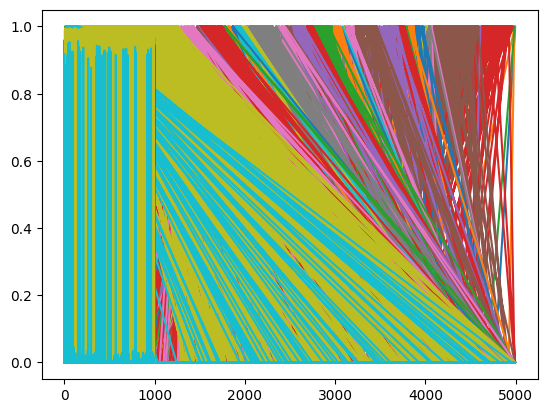

In [75]:
plt.plot(Y_test)
plt.plot(y_pred)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

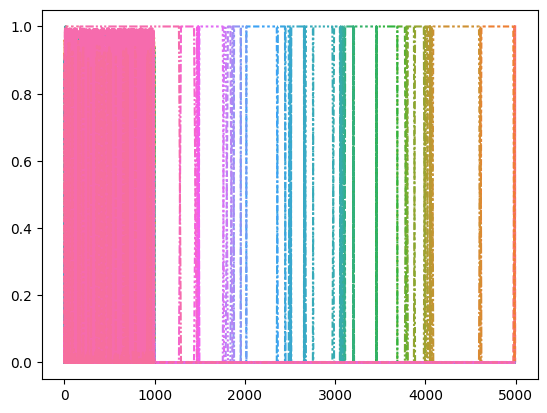

In [79]:
sns.lineplot(Y_test)
sns.lineplot(y_pred,color="red")
plt.legend().set_visible(False)

<Axes: >

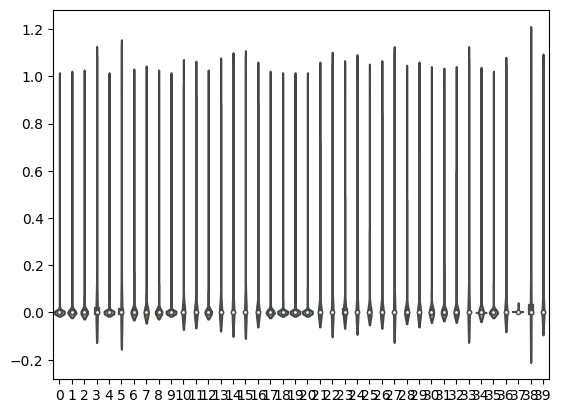

In [81]:
sns.violinplot(Y_test)
sns.violinplot(y_pred,color="red")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_36/121385742.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular

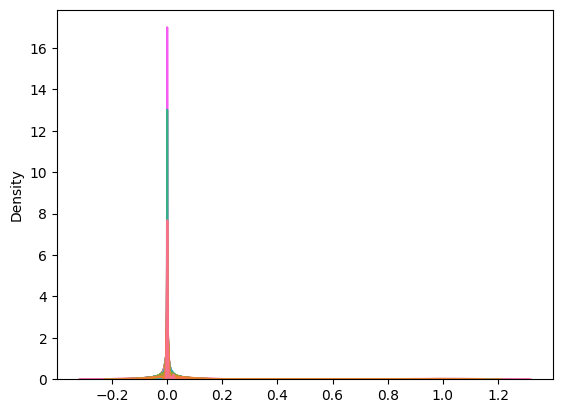

In [83]:
sns.kdeplot(Y_test)
sns.kdeplot(y_pred)
plt.legend().set_visible(False)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: ylabel='Count'>

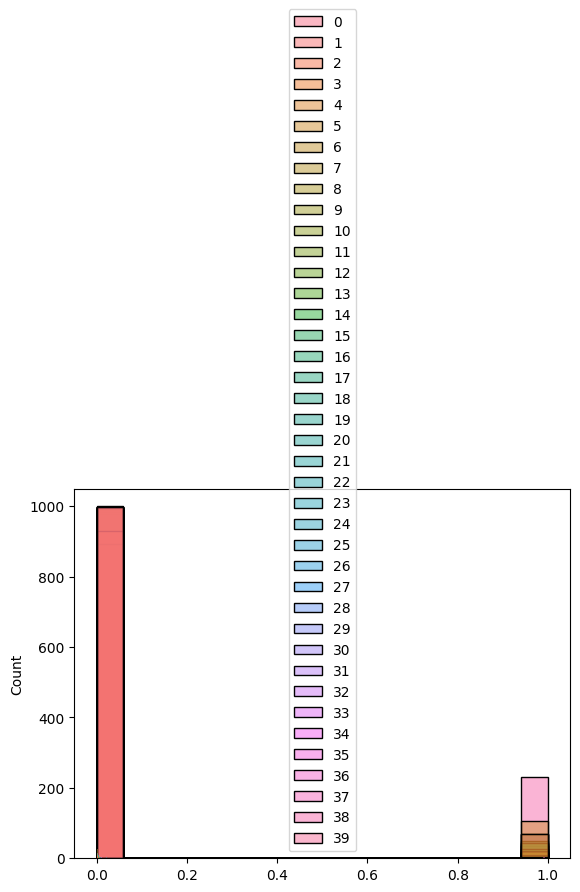

In [84]:
sns.histplot(Y_test)
sns.histplot(y_pred,color="red",kde=True)

<Axes: >

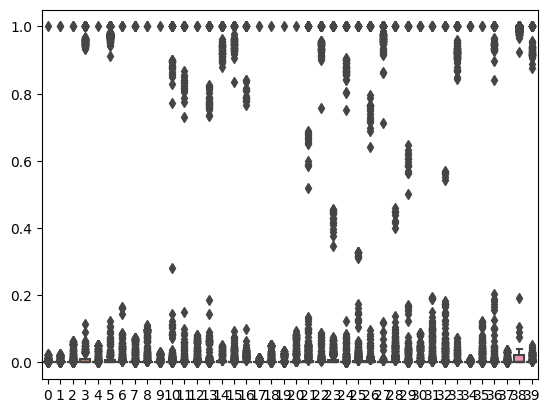

In [85]:
sns.boxplot(Y_test)
sns.boxplot(y_pred)